In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np

import pandas as pd
import yaml 

from PLBenchmarks import targets, ligands, edges
from rdkit import Chem
from tqdm.notebook import tqdm
import pint
unit_registry = pint.UnitRegistry()
from openforcefield.topology import Topology, Molecule
from openforcefield.typing.engines.smirnoff import ForceField

import benchmarkpl
path = benchmarkpl.__path__[0]

In [2]:
forcefield1 = ForceField('openff-2.0.0.offxml')
forcefield2 = ForceField('openff-2.1.0.offxml')

In [3]:
dfs = []

In [4]:
bonds1 = forcefield1.get_parameter_handler("Bonds").to_dict()
bonds2 = forcefield2.get_parameter_handler("Bonds").to_dict()
bonds1_df = pd.DataFrame(bonds1["Bond"])
bonds1_df.index = bonds1_df.id
bonds2_df = pd.DataFrame(bonds2["Bond"])
bonds2_df.index = bonds2_df.id
for b, row in bonds1_df.iterrows():
    new_p = b
    for t in ["length", "k"]:
        diff = bonds2_df.loc[new_p, t] - row[t]
        bonds2_df.loc[new_p, f"change_{t}"] = float(str(diff).split(" ")[0])
bonds2_df["big_change"] = 0
bonds2_df["max_change"] = 0
for t in ["length", "k"]:
    std = bonds2_df[f"change_{t}"].std()
    bonds2_df[f"change_{t}"] = bonds2_df[f"change_{t}"] / std
    for b, row in bonds2_df.iterrows():
        if np.fabs(row["max_change"]) <  np.fabs(row[f"change_{t}"]):
            bonds2_df.loc[b, "max_change"] = row[f"change_{t}"]
        if np.fabs(row[f"change_{t}"]) > 2:
            bonds2_df.loc[b, "big_change"] = 3
        elif np.fabs(row[f"change_{t}"]) > 1:
            bonds2_df.loc[b, "big_change"] = 2
        elif np.fabs(row[f"change_{t}"]) > 1e-6:
            bonds2_df.loc[b, "big_change"] = 1
dfs.append(bonds2_df[["id", "smirks", "max_change", "big_change"]])
bonds2_df["big_change"].sum()

96

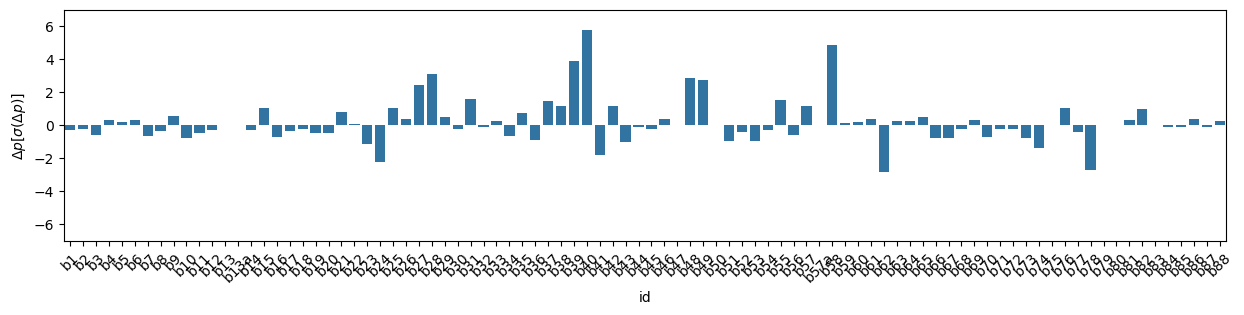

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(15,3))
sns.barplot(data=bonds2_df,  x="id", y="max_change", color=sns.color_palette()[0])
plt.ylabel(r'$\Delta p [\sigma(\Delta p)]$')
plt.ylim(-7,7)
t = plt.xticks(rotation=45)
plt.savefig('01e_bonds_change.png', bbox_inches="tight")

In [6]:
para1 = forcefield1.get_parameter_handler("Angles").to_dict()
para2 = forcefield2.get_parameter_handler("Angles").to_dict()
para1_df = pd.DataFrame(para1["Angle"])
para1_df.index = para1_df.id
para2_df = pd.DataFrame(para2["Angle"])
para2_df.index = para2_df.id
for b, row in para1_df.iterrows():
    new_p = b
    for t in ['angle', 'k']:
        v1 = float(str(para2_df.loc[new_p, t]).split(" ")[0])
        v2 = float(str(row[t]).split(" ")[0])
        para2_df.loc[new_p, f"change_{t}"] = v2 - v1
para2_df["big_change"] = 0
para2_df["max_change"] = 0
for t in ['angle', 'k']:
    std = para2_df[f"change_{t}"].std()
    para2_df[f"change_{t}"] = para2_df[f"change_{t}"] / std
    if std < 1e-15:
        continue
    for b, row in para2_df.iterrows():
        if np.fabs(row["max_change"]) <  np.fabs(row[f"change_{t}"]):
            para2_df.loc[b, "max_change"] = row[f"change_{t}"]
        if np.fabs(row[f"change_{t}"]) > 2:
            para2_df.loc[b, "big_change"] = 3
        elif np.fabs(row[f"change_{t}"]) > 1:
            para2_df.loc[b, "big_change"] = 2   
        elif np.fabs(row[f"change_{t}"]) > 1e-6:
            para2_df.loc[b, "big_change"] = 1    
dfs.append(para2_df[["id", "smirks", "max_change", "big_change"]])                   
para2_df["big_change"].sum()

55

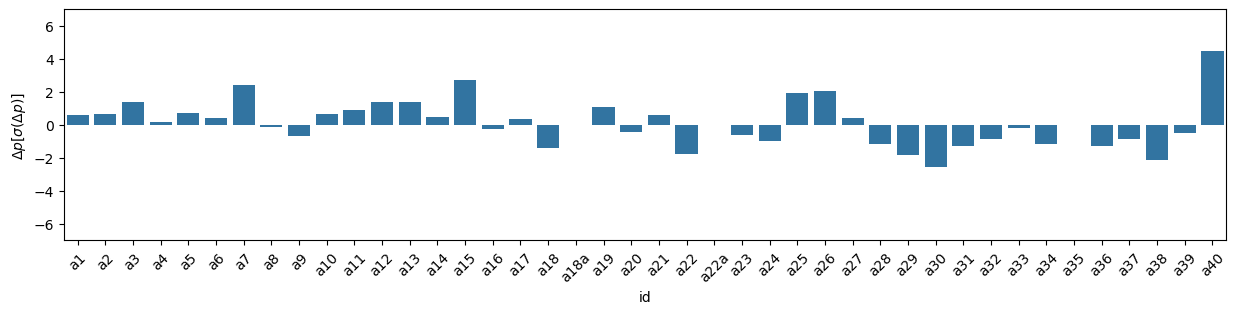

In [7]:
fig = plt.figure(figsize=(15,3))
sns.barplot(data=para2_df, x="id", y="max_change", color=sns.color_palette()[0])
plt.ylabel(r'$\Delta p [\sigma(\Delta p)]$')
plt.ylim(-7,7)
t = plt.xticks(rotation=45)
plt.savefig('01e_angles_change.png', bbox_inches="tight")

In [8]:
torsions1 = forcefield1.get_parameter_handler("ProperTorsions").to_dict()
torsions2 = forcefield2.get_parameter_handler("ProperTorsions").to_dict()
# print(torsions1)
torsions1_df = pd.DataFrame(torsions1["Proper"])
torsions1_df.index = torsions1_df.id
torsions2_df = pd.DataFrame(torsions2["Proper"])
torsions2_df.index = torsions2_df.id
for b, row in torsions1_df.iterrows():
    new_p = b
    for t in ['periodicity1', 'phase1', 'k1', 'idivf1',
       'periodicity2', 'periodicity3', 'phase2', 'phase3', 'k2', 'k3',
       'idivf2', 'idivf3', 'periodicity4', 'periodicity5', 'phase4', 'phase5',
       'k4', 'k5', 'idivf4', 'idivf5', 'periodicity6', 'phase6', 'k6',
       'idivf6']:
        v1 = float(str(torsions2_df.loc[new_p, t]).split(" ")[0])
        v2 = float(str(row[t]).split(" ")[0])
        torsions2_df.loc[new_p, f"change_{t}"] = v2 - v1
torsions2_df["big_change"] = 0
torsions2_df["max_change"] = 0
for t in ['periodicity1', 'phase1', 'k1', 'idivf1',
       'periodicity2', 'periodicity3', 'phase2', 'phase3', 'k2', 'k3',
       'idivf2', 'idivf3', 'periodicity4', 'periodicity5', 'phase4', 'phase5',
       'k4', 'k5', 'idivf4', 'idivf5', 'periodicity6', 'phase6', 'k6',
       'idivf6']:
    std = torsions2_df[f"change_{t}"].std()
    torsions2_df[f"change_{t}"] = torsions2_df[f"change_{t}"] / std
    print(std)
    if std < 1e-15:
        continue
    for b, row in torsions2_df.iterrows():
        if np.fabs(row["max_change"]) <  np.fabs(row[f"change_{t}"]):
            torsions2_df.loc[b, "max_change"] = row[f"change_{t}"]
        if np.fabs(row[f"change_{t}"]) > 2:
            torsions2_df.loc[b, "big_change"] = 3
        elif np.fabs(row[f"change_{t}"]) > 1:
            torsions2_df.loc[b, "big_change"] = 2  
        elif np.fabs(row[f"change_{t}"]) > 1e-6:
            torsions2_df.loc[b, "big_change"] = 1 
dfs.append(torsions2_df[["id", "smirks", "max_change", "big_change"]])                       
torsions2_df["big_change"].sum()

0.0773823232534137
13.928818185614466
2.300556660956521
0.0
0.0
0.0
0.0
0.0
0.9606674292355968
0.6997684371512484
0.0
0.0
0.0
0.0
0.0
0.0
0.2607904499986314
0.7285200518368156
0.0
0.0
0.0
0.0
1.0836399658664517
0.0


206

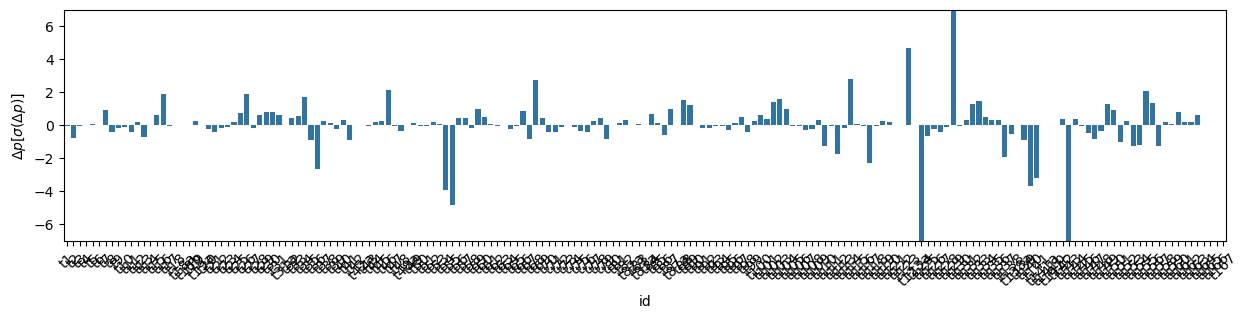

In [9]:
fig = plt.figure(figsize=(15,3))
sns.barplot(data=torsions2_df, x="id", y="max_change", color=sns.color_palette()[0])
plt.ylabel(r'$\Delta p [\sigma(\Delta p)]$')
plt.ylim(-7,7)
t = plt.xticks(rotation=45)
plt.savefig('01e_torsions_change.png', bbox_inches="tight")

In [10]:
torsions1 = forcefield1.get_parameter_handler("ImproperTorsions").to_dict()
torsions2 = forcefield2.get_parameter_handler("ImproperTorsions").to_dict()
# print(torsions1)
torsions1_df = pd.DataFrame(torsions1["Improper"])
torsions1_df.index = torsions1_df.id
torsions2_df = pd.DataFrame(torsions2["Improper"])
torsions2_df.index = torsions2_df.id
for b, row in torsions1_df.iterrows():
    new_p = b
    print(row)
    for t in ['periodicity1', 'phase1', 'k1']:
        v1 = float(str(torsions2_df.loc[new_p, t]).split(" ")[0])
        v2 = float(str(row[t]).split(" ")[0])
        torsions2_df.loc[new_p, f"change_{t}"] = v2 - v1
torsions2_df["big_change"] = 0
torsions2_df["max_change"] = 0
for t in ['periodicity1', 'phase1', 'k1']:
    std = torsions2_df[f"change_{t}"].std()
    torsions2_df[f"change_{t}"] = torsions2_df[f"change_{t}"] / std
    print(std)
    if std < 1e-15:
        continue
    for b, row in torsions2_df.iterrows():
        if np.fabs(row["max_change"]) <  np.fabs(row[f"change_{t}"]):
            torsions2_df.loc[b, "max_change"] = row[f"change_{t}"]
        if np.fabs(row[f"change_{t}"]) > 2:
            torsions2_df.loc[b, "big_change"] = 3
        elif np.fabs(row[f"change_{t}"]) > 1:
            torsions2_df.loc[b, "big_change"] = 2
        elif np.fabs(row[f"change_{t}"]) > 1e-6:
            torsions2_df.loc[b, "big_change"] = 1  
dfs.append(torsions2_df[["id", "smirks", "max_change", "big_change"]])                  
torsions2_df["big_change"].sum()

smirks          [*:1]~[#6X3:2](~[*:3])~[*:4]
periodicity1                               2
phase1                             180.0 deg
k1                              1.1 kcal/mol
id                                        i1
Name: i1, dtype: object
smirks          [*:1]~[#6X3:2](~[#8X1:3])~[#8:4]
periodicity1                                   2
phase1                                 180.0 deg
k1                                 10.5 kcal/mol
id                                            i2
Name: i2, dtype: object
smirks          [*:1]~[#7X3$(*~[#15,#16](!-[*])):2](~[*:3])~[*:4]
periodicity1                                                    2
phase1                                                  180.0 deg
k1                                                   1.1 kcal/mol
id                                                             i3
Name: i3, dtype: object
smirks          [*:1]~[#7X3$(*~[#6X3]):2](~[*:3])~[*:4]
periodicity1                                          2
phase1          

10

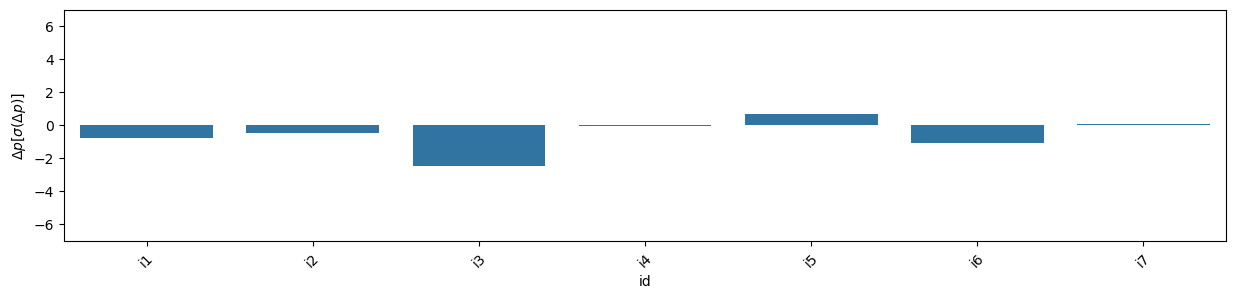

In [11]:
fig = plt.figure(figsize=(15,3))
sns.barplot(data=torsions2_df, x="id", y="max_change", color=sns.color_palette()[0])
plt.ylabel(r'$\Delta p [\sigma(\Delta p)]$')
plt.ylim(-7,7)
t = plt.xticks(rotation=45)
plt.savefig('01e_improper_change.png', bbox_inches="tight")

In [12]:
para1 = forcefield1.get_parameter_handler("vdW").to_dict()
para2 = forcefield2.get_parameter_handler("vdW").to_dict()
para1_df = pd.DataFrame(para1["Atom"])
para1_df.index = para1_df.id
para2_df = pd.DataFrame(para2["Atom"])
para2_df.index = para2_df.id
for b, row in para1_df.iterrows():
    new_p = b
    for t in ['epsilon', 'rmin_half']:
        v1 = float(str(para2_df.loc[new_p, t]).split(" ")[0])
        v2 = float(str(row[t]).split(" ")[0])
        para2_df.loc[new_p, f"change_{t}"] = v2 - v1
para2_df["big_change"] = 0
para2_df["max_change"] = 0
for t in ['epsilon', 'rmin_half']:
    std = para2_df[f"change_{t}"].std()
    para2_df[f"change_{t}"] = para2_df[f"change_{t}"] / std
    if std < 1e-15:
        continue
    for b, row in para2_df.iterrows():
        if np.fabs(row["max_change"]) <  np.fabs(row[f"change_{t}"]):
            para2_df.loc[b, "max_change"] = row[f"change_{t}"]
        if np.fabs(row[f"change_{t}"]) > 2:
            para2_df.loc[b, "big_change"] = 3
        elif np.fabs(row[f"change_{t}"]) > 1:
            para2_df.loc[b, "big_change"] = 2
        elif np.fabs(row[f"change_{t}"]) > 1e-6:
            para2_df.loc[b, "big_change"] = 1 
dfs.append(para2_df[["id", "smirks", "max_change", "big_change"]])                         
para2_df["big_change"].sum()

0

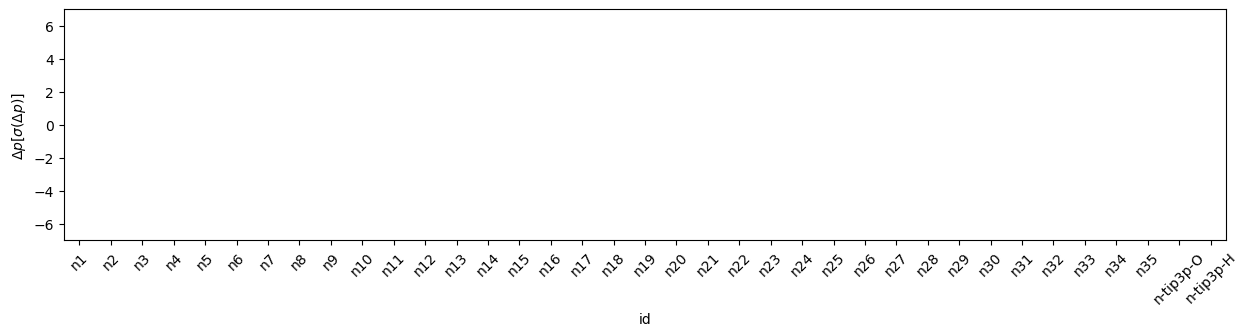

In [13]:
fig = plt.figure(figsize=(15,3))
sns.barplot(data=para2_df, x="id", y="max_change", color=sns.color_palette()[0])
plt.ylabel(r'$\Delta p [\sigma(\Delta p)]$')
plt.ylim(-7,7)
t = plt.xticks(rotation=45)
plt.savefig('01e_vdW_change.png', bbox_inches="tight")

In [14]:
all_parameters = pd.concat(dfs)
all_parameters.to_csv("01d_off_parameter_changes.csv")